In [1]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data._utils.collate import default_collate

cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

In [2]:
from torch.utils.data import DataLoader
from src.utils import load_model
from src.problems import EVRP
# from src.graph.evrp_network import EVRPNetwork

In [3]:
model, _ = load_model('../../outputs/evrp_4/rollout_20230612T204609')
model.eval()  # Put in evaluation mode to not track gradients

  [*] Loading model from ../../outputs/evrp_4/rollout_20230612T204609/epoch-4.pt


AttentionEVRPModel(
  (init_embed_node): Linear(in_features=5, out_features=128, bias=True)
  (project_node_embeddings): Linear(in_features=128, out_features=384, bias=False)
  (project_fixed_context): Linear(in_features=128, out_features=128, bias=False)
  (encoder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiHeadAtten

In [4]:
env = EVRP
val_dataset = env.make_dataset(
        size=4,
        num_samples=3,
        num_trucks=2,
        num_trailers=3,
        truck_names=None,
    )

In [5]:
def collate_fn(batch):
    data_batch, graph_batch = zip(*batch)

    return default_collate(data_batch), list(graph_batch)


In [6]:
def tensor_to_tuples(tensor):
    batch_size, features, time = tensor.shape
    edges = []
    for b in range(batch_size):
        batch_list = tuple(tensor[b, :, time - 1].tolist())
        edges.append([batch_list])

    return edges

!!!!!!!!!!!DONE!!!!!!!!!  9
graph_index 0
[(0, 1, {}), (0, 2, {}), (0, 3, {}), (1, 0, {}), (1, 2, {}), (1, 2, {'truck': 'Truck B', 'trailer': 'Trailer 1', 'timestamp': 3, 'color': array([0.50392157, 0.99998103, 0.70492555, 1.        ]), 'style': (0, (1, 2)), 'label': '3'}), (1, 2, {'truck': 'Truck A', 'trailer': 'Trailer 2', 'timestamp': 4, 'color': array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00]), 'style': 'solid', 'label': '4'}), (1, 3, {}), (2, 0, {}), (2, 1, {}), (2, 1, {'truck': 'Truck A', 'trailer': 'Trailer 0', 'timestamp': 2, 'color': array([0.5, 0. , 1. , 1. ]), 'style': 'solid', 'label': '2'}), (2, 3, {}), (2, 2, {'truck': 'Truck B', 'trailer': None, 'timestamp': 5, 'color': 'black', 'style': (0, (1, 2)), 'label': '5'}), (2, 2, {'truck': 'Truck A', 'trailer': None, 'timestamp': 6, 'color': 'black', 'style': 'solid', 'label': '6'}), (2, 2, {'truck': 'Truck B', 'trailer': None, 'timestamp': 7, 'color': 'black', 'style': (0, (1, 2)), 'label': '7'}), (2, 2, {'t

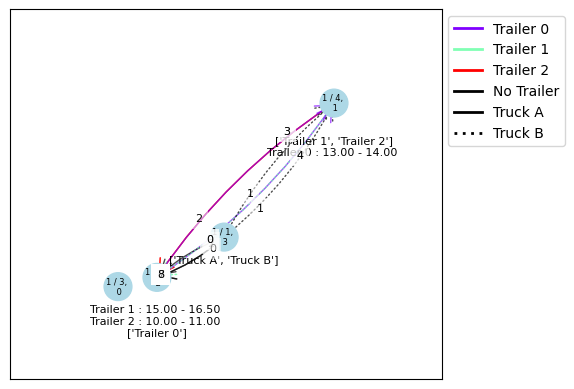

graph_index 1
[(0, 1, {}), (0, 2, {}), (0, 3, {}), (0, 3, {'truck': 'Truck A', 'trailer': 'Trailer 0', 'timestamp': 4, 'color': array([0.5, 0. , 1. , 1. ]), 'style': 'solid', 'label': '4'}), (0, 3, {'truck': 'Truck B', 'trailer': None, 'timestamp': 5, 'color': 'black', 'style': (0, (1, 2)), 'label': '5'}), (1, 0, {}), (1, 2, {}), (1, 3, {}), (1, 3, {'truck': 'Truck A', 'trailer': None, 'timestamp': 0, 'color': 'black', 'style': 'solid', 'label': '0'}), (1, 3, {'truck': 'Truck B', 'trailer': None, 'timestamp': 1, 'color': 'black', 'style': (0, (1, 2)), 'label': '1'}), (1, 1, {'truck': 'Truck A', 'trailer': None, 'timestamp': 8, 'color': 'black', 'style': 'solid', 'label': '8'}), (2, 0, {}), (2, 1, {}), (2, 3, {}), (3, 0, {}), (3, 0, {'truck': 'Truck A', 'trailer': None, 'timestamp': 2, 'color': 'black', 'style': 'solid', 'label': '2'}), (3, 0, {'truck': 'Truck B', 'trailer': None, 'timestamp': 3, 'color': 'black', 'style': (0, (1, 2)), 'label': '3'}), (3, 0, {'truck': 'Truck B', 'traile

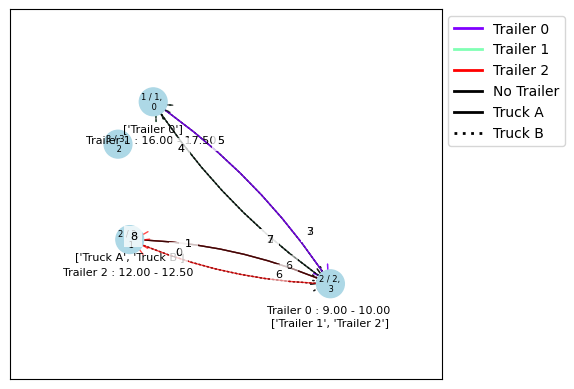

graph_index 2
[(0, 1, {}), (0, 2, {}), (0, 3, {}), (0, 3, {'truck': 'Truck B', 'trailer': 'Trailer 0', 'timestamp': 1, 'color': array([0.5, 0. , 1. , 1. ]), 'style': (0, (1, 2)), 'label': '1'}), (0, 3, {'truck': 'Truck A', 'trailer': None, 'timestamp': 2, 'color': 'black', 'style': 'solid', 'label': '2'}), (0, 3, {'truck': 'Truck B', 'trailer': None, 'timestamp': 7, 'color': 'black', 'style': (0, (1, 2)), 'label': '7'}), (1, 0, {}), (1, 0, {'truck': 'Truck A', 'trailer': None, 'timestamp': 0, 'color': 'black', 'style': 'solid', 'label': '0'}), (1, 2, {}), (1, 3, {}), (2, 0, {}), (2, 0, {'truck': 'Truck B', 'trailer': 'Trailer 2', 'timestamp': 5, 'color': array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00]), 'style': (0, (1, 2)), 'label': '5'}), (2, 1, {}), (2, 3, {}), (2, 3, {'truck': 'Truck A', 'trailer': None, 'timestamp': 6, 'color': 'black', 'style': 'solid', 'label': '6'}), (3, 0, {}), (3, 1, {}), (3, 1, {'truck': 'Truck A', 'trailer': 'Trailer 1', 'timestamp': 8, '

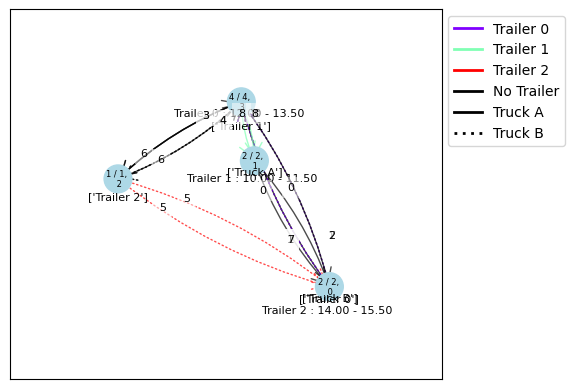

In [10]:
# Need a dataloader to batch instances
dataloader = DataLoader(val_dataset, batch_size=1000, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    length, _, edges = model(batch[0], batch[1], return_pi=True)

# add edges that where visited
# edges = [
#     (0, 3, 1, 1, 1),
#     (0, 3, 0, None, 2),
#     (3, 2, 1, 0, 3),
#     (3, 2, 0, 2, 4),
# ]

edges=edges.transpose(0, 1)
edges=edges.transpose(1, 2)
for i, graph in enumerate(batch[1]):
    print("graph_index", i)
    print(graph._edges)
    print(graph._nodes)
    print(edges[i])
    fig, ax = plt.subplots()
    # for edge in edges[i].tolist():
    graph.visit_edge(edges[i].tolist())    
    graph.draw(ax=ax, with_labels=True)
    plt.show()